In [1]:
import re
import copy
import logging
import tempfile
from pathlib import Path
from io import BytesIO
from xml.dom import minidom

import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import lxml.etree as et
import cssutils

from PIL import Image
import cairosvg
from skimage.transform import resize
from svg.path import parse_path

import IPython
from IPython.display import SVG
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import MolDrawOptions

In [2]:
%load_ext autoreload
%autoreload 2
from nncomp_molecule import constants
from nncomp_molecule.preprocessors import MolecularBBoxGenerator, SaltAndPepperNoise

In [3]:
train_df = pd.read_csv(constants.COMPETITION_DATADIR / "train_labels.csv", nrows=100)

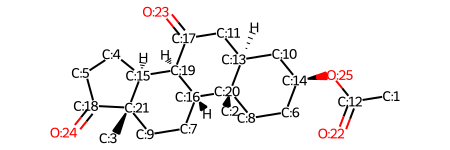

In [4]:
INDEX = 1
sample = train_df.iloc[INDEX]
mol = Chem.inchi.MolFromInchi(sample.InChI)
for atom in mol.GetAtoms():
    atom.SetProp('molAtomMapNumber', str(atom.GetIdx() + 1))
mol

InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3


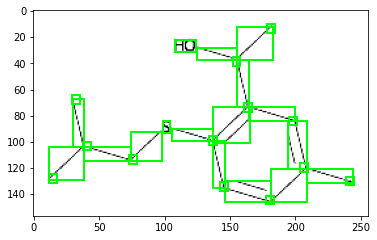

,type,idx,x_min,y_min,x_max,y_max,label,n_Hs
0,atom,0,11.359275,124.89325,17.421775,131.31825,C,3
1,atom,1,29.330000,64.48850,35.392500,70.91350,C,3
2,atom,2,238.578250,126.74050,244.640750,133.16550,C,3
3,atom,3,178.347250,10.19500,184.409750,16.62000,C,3
4,atom,4,177.280750,141.38000,183.343250,147.80500,C,1
5,atom,5,142.406000,131.00450,148.468500,137.42950,C,1
6,atom,6,195.251500,80.97525,201.314000,87.40025,C,1
7,atom,7,72.656750,110.25400,78.719250,116.67900,C,2
8,atom,8,37.782000,99.87850,43.844500,106.30350,C,1
9,atom,9,203.703500,116.36525,209.766000,122.79025,C,0


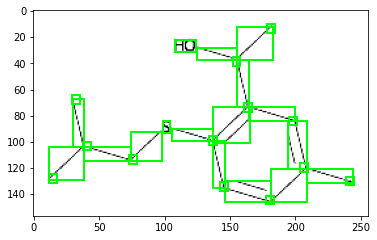

In [8]:
from typing import List, Tuple

import matplotlib.patches as patches
import numpy as np
from PIL import Image


def add_bboxes_to_image(
    ax, image: np.ndarray,
    bboxes: List[Tuple[int, int, int, int]],
    labels: List[str] = None,
    label_size: int = 10,
    line_width: int = 2,
    border_color=(0, 1, 0, 1)
):
    """
    Add bbox to ax

    :param image: dtype=np.uint8
    :param bbox: [(x_min, y_min, x_max, y_max)]
    :param label: List[str] or None
    :return: ax
    """
    # Display the image
    ax.imshow(image)

    if labels is None:
        labels = [None] * len(bboxes)

    for bbox, label in zip(bboxes, labels):
        # Add bounding box
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=line_width,
                                 edgecolor=border_color,
                                 facecolor='none')
        ax.add_patch(rect)

        # label
        if label:
            bbox_props = dict(boxstyle="square,pad=0",
                              linewidth=line_width, facecolor=border_color,
                              edgecolor=border_color)
            ax.text(x_min, y_min, label,
                    ha="left", va="bottom", rotation=0,
                    size=label_size, bbox=bbox_props)
    return ax


INDEX = 0

sample = train_df.iloc[INDEX]
generator = MolecularBBoxGenerator()
image, noised_image, svg, annotation_df = generator(sample.InChI)

print(sample.InChI)
bboxes = annotation_df[["x_min", "y_min", "x_max", "y_max"]].values
labels = annotation_df.label + annotation_df.idx.astype(str)
fig, ax = plt.subplots()
add_bboxes_to_image(ax, image, bboxes)
display(fig)
with pd.option_context("display.max_rows", None):
    display(annotation_df)

In [10]:
type(svg)

lxml.etree._Element

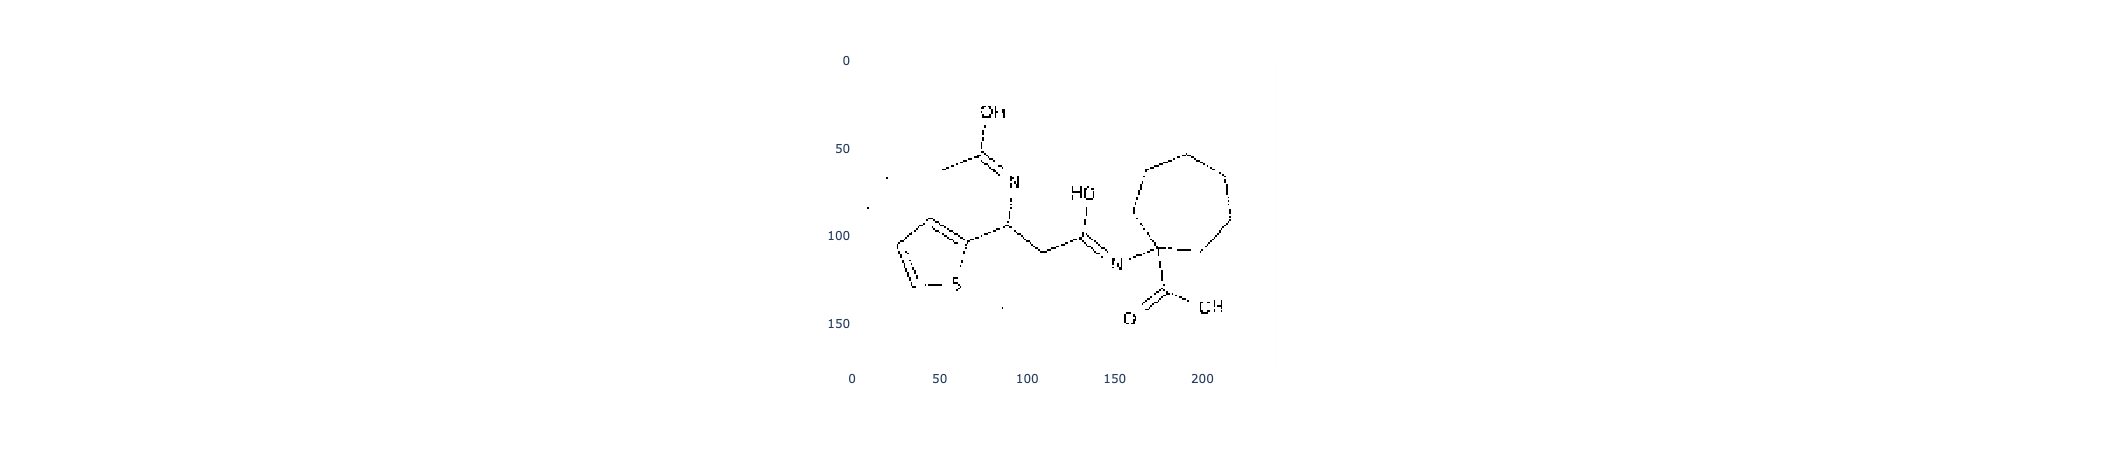

In [14]:
def image_id2path(x):
    return constants.COMPETITION_DATADIR / f"train/{x[0]}/{x[1]}/{x[2]}/{x}.png"


original_image = cv2.imread(str(image_id2path(sample.image_id)))
px.imshow(original_image)

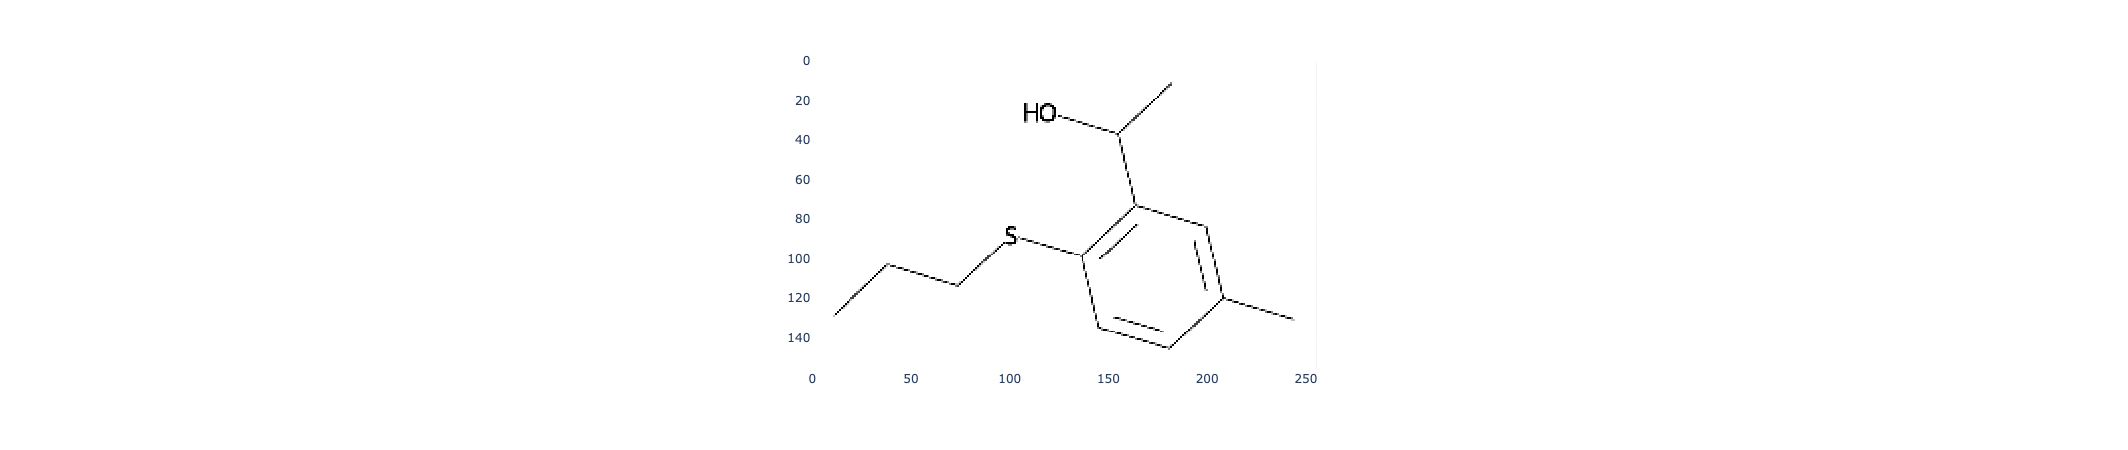

In [7]:
with tempfile.TemporaryDirectory() as tempdir:
    Image.fromarray(image).save(f"{tempdir}/temp.png")
    loaded_image = cv2.imread(f"{tempdir}/temp.png")
px.imshow(loaded_image)

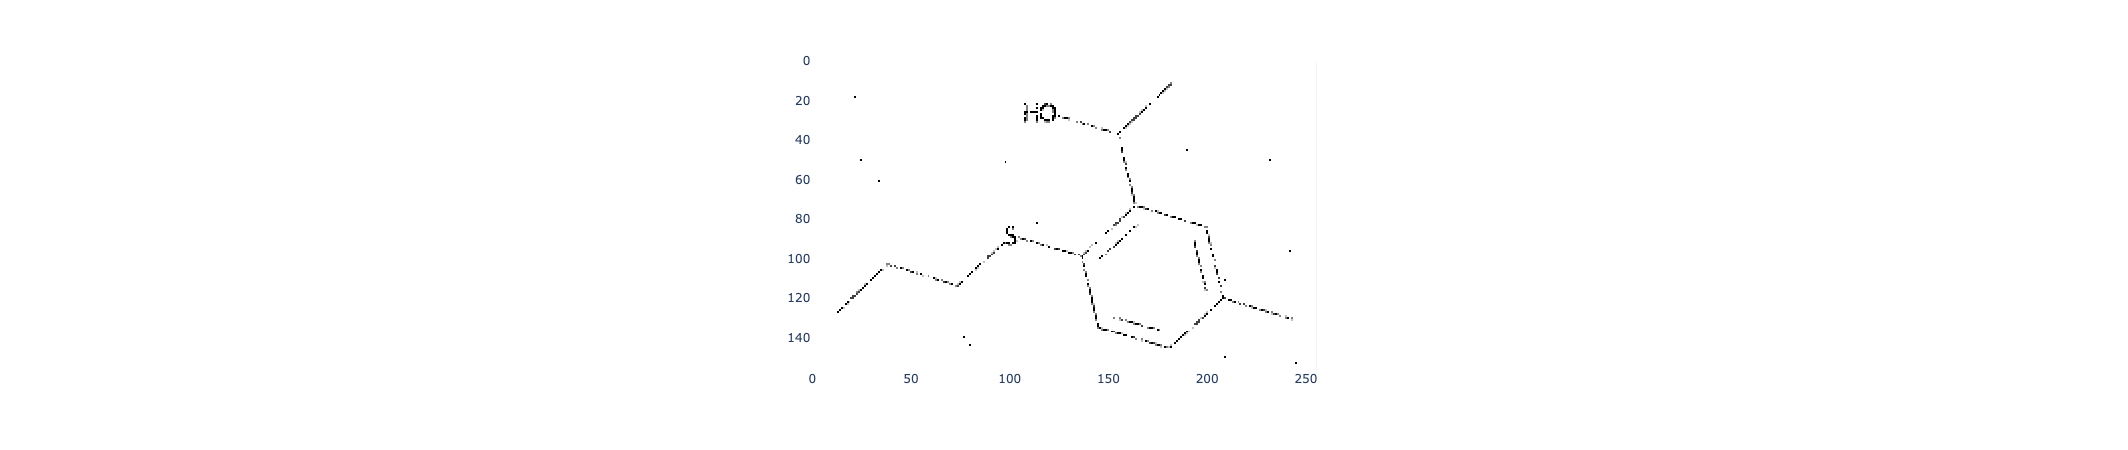

In [8]:
transform = SaltAndPepperNoise()
noised_image = transform.apply(loaded_image)
px.imshow(noised_image)